In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import MultipleLocator

In [4]:
import os
import os.path as osp

In [6]:
# define class stiModel
class stiModel(nn.Module):
  def __init__(self, model):
      super(stiModel, self).__init__()
      self.features = nn.Sequential(*list(model.children())[0][:30])
      for param in self.features.parameters():
        param.requires_grad_ = False

  def forward(self, x):
      x = self.features(x)
      return x 

In [7]:
# define class tgModel
class tgModel(nn.Module):
  def __init__(self, model):
      super(tgModel, self).__init__()
      self.features = nn.Sequential(*list(model.children())[0][:30])
      # self.pool_layer = nn.AdaptiveMaxPool2d((1, 1))
      for param in self.features.parameters():
        param.requires_grad_ = False

  def forward(self, x):
      x = self.features(x)
      # x = self.pool_layer(x)
      return x 

In [5]:
cmodel = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
model_stimuli = stiModel(cmodel)
model_target = tgModel(cmodel)

In [9]:
from torch.nn.modules.conv import Conv2d
ConvSize, NumTemplates, Mylayer = 1, 512, 31
TotalTrials, targetsize, stimulisize = 600, 32, 224
MMconv = Conv2d(NumTemplates, 1, kernel_size = (ConvSize, ConvSize), stride = (1, 1), padding = (1, 1))

In [10]:
from PIL import Image

data_transforms_stimu = transforms.Compose([
        transforms.Resize((stimulisize, stimulisize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_transforms_target = transforms.Compose([
        transforms.Resize((targetsize, targetsize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [11]:
class MyDataset(Dataset): 
  def __init__(self, path_dir, transform=None): 
    self.path_dir = path_dir 
    self.transform = transform 
    self.images = os.listdir(self.path_dir)

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image_index = self.images[idx]
    img_path = os.path.join(self.path_dir, image_index)
    print(img_path)
    img = Image.open(img_path).convert('RGB')
    
    if self.transform is not None:
      img = self.transform(img)

    return img

/content/drive/MyDrive/Colab Notebooks/sampleimg/array/array_2.jpg
torch.Size([3, 224, 224])
/content/drive/MyDrive/Colab Notebooks/sampleimg/target/target_2.jpg
torch.Size([3, 32, 32])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 32, 32])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 2, 2])
torch.Size([1, 512, 2, 2])
torch.Size([1, 15, 15])
<class 'torch.Tensor'>


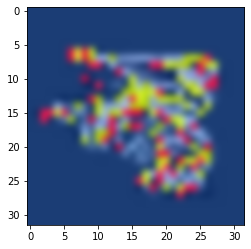

In [17]:
path_dir_array = '/content/drive/MyDrive/Colab Notebooks/sampleimg/array'
path_dir_target = '/content/drive/MyDrive/Colab Notebooks/sampleimg/target'

out = 0
for i in range(1):
  stimuli_data = MyDataset(path_dir_array, data_transforms_stimu)
  target_data= MyDataset(path_dir_target, data_transforms_target)
  
  stimuli = stimuli_data[i]
  print(stimuli.shape)
  # plt.imshow(transforms.ToPILImage()(stimuli), interpolation="bicubic")
  
  target = target_data[i]
  print(target.shape)
  plt.imshow(transforms.ToPILImage()(target), interpolation="bicubic")

  stimuli = stimuli.view(1, 3, 224, 224)
  print(stimuli.size())

  target = target.view(1, 3, 32, 32)
  print(target.shape)

  output_stimuli = model_stimuli.forward(stimuli)
  print(output_stimuli.shape)
  # plt.imshow(transforms.ToPILImage()(output_stimuli[0]), interpolation="bicubic")

  output_target = model_target.forward(target)
  print(output_target.shape)
  
  MMconv.weight = torch.nn.Parameter(output_target)
  print(MMconv.weight.shape)

  out = MMconv.forward(output_stimuli).squeeze(0)
  print(out.size())
  print(type(out))
  # print(out)
#   plt.imshow(transforms.ToPILImage()(out.squeeze(0)), interpolation="bicubic")



**Define function to visualize attention map of array**

In [13]:
def VisualizeArray(OutAttention):
    resize = transforms.Resize((224, 224))
    OutAttention = resize(OutAttention)
    OutAttention = torch.divide(OutAttention, 255.0)
    stimuli_img = MyDataset(path_dir_array, resize)[0]
    plt.imshow(stimuli_img)
    plt.imshow(transforms.ToPILImage()(OutAttention), cmap = plt.cm.jet, interpolation="bicubic", alpha = 0.3)
    plt.colorbar()

/content/drive/MyDrive/Colab Notebooks/sampleimg/array/array_2.jpg


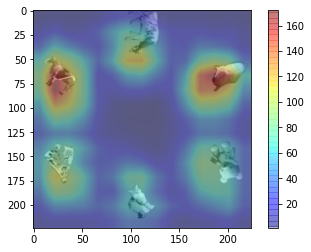

In [14]:
VisualizeArray(out)

**Function to deal with search process**

                position3
    position2              position4
    position1              position5
                position6

In [ ]:
# read ground truth through pandas
df_gd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GroundTruth.csv')
df_gd['arrayCate'] = df_gd['arrayCate'].apply(lambda x: pd.to_numeric(list(x.split(','))))
df_gd['targetCate'] = df_gd['targetCate'].apply(lambda x : int(x))
df_gd['PicNo'] = df_gd['PicNo'].apply(lambda x : int(x))
df_gd.drop(columns='PicNo', inplace=True)
df_gd.index = range(1, 301)

In [ ]:
df_gd.head()

,targetName,targetCate,arrayCate
1,cat,16,"[16, 20, 18, 19, 34, 78]"
2,horse,18,"[34, 18, 20, 19, 78, 16]"
3,sheep,19,"[34, 78, 18, 19, 20, 16]"
4,cow,20,"[20, 19, 78, 34, 18, 16]"
5,kite,34,"[19, 16, 18, 20, 78, 34]"


In [ ]:
df_gd.loc[1, 'arrayCate']

array([16, 20, 18, 19, 34, 78])

Load and read mask .mat file

In [ ]:
from scipy.io import loadmat

In [ ]:
# load mask of 6 positions
mask_dir = '/content/drive/MyDrive/Colab Notebooks/ObjectArray/saliencyMask/'
mask_dic = {'pos'+str(i) : None for i in range(1, 7)}
for i in range(1, 7):
    dir = mask_dir + 'mask' + str(i) + '.mat'
    mask_dic['pos'+str(i)] = torch.from_numpy(loadmat(dir)['mask'])

width, height = mask_dic['pos1'].shape
print(width, height)

756 676


In [ ]:
resize_mask = transforms.Resize((224, 224))
# resize masks of 6 positions
for i in range(1, 7):
    mask_dic['pos'+str(i)] = resize_mask(mask_dic['pos'+str(i)].view(-1, width, height))
    plt.imshow(transforms.ToPILImage()(mask_dic['pos'+str(i)]), interpolation="bicubic")
    plt.show()

In [ ]:
positions = []

Locate 6 masks after resize

In [ ]:
# area where position 1 is masked
# x: rows, y: cols
y1_pos1 = 0
x1_pos1 = min(np.where(mask_dic['pos1'][0,:,y1_pos1].numpy() == 1)[0])

x2_pos1 = max(np.where(mask_dic['pos1'][0,:,y1_pos1].numpy() == 1)[0])
y2_pos1 = max(np.where(mask_dic['pos1'][0,x2_pos1,:].numpy() == 1)[0])

cx_pos1 = (x1_pos1 + x2_pos1) // 2
cy_pos1 = (y1_pos1 + y2_pos1) // 2

# area where position 2 is masked
y1_pos2 = 0
x1_pos2 = min(np.where(mask_dic['pos2'][0,:,y1_pos2].numpy() == 1)[0])

x2_pos2 = max(np.where(mask_dic['pos2'][0,:,y1_pos2].numpy() == 1)[0])
y2_pos2 = max(np.where(mask_dic['pos2'][0,x2_pos2,:].numpy() == 1)[0])

cx_pos2 = (x1_pos2 + x2_pos2) // 2
cy_pos2 = (y1_pos2 + y2_pos2) // 2

# area where position 3 is masked
x1_pos3 = 0
y1_pos3 = min(np.where(mask_dic['pos3'][0,x1_pos3,:].numpy() == 1)[0])

y2_pos3 = max(np.where(mask_dic['pos3'][0,x1_pos3,:].numpy() == 1)[0])
x2_pos3 = max(np.where(mask_dic['pos3'][0,:,y2_pos3].numpy() == 1)[0])

cx_pos3 = (x1_pos3 + x2_pos3) // 2
cy_pos3 = (y1_pos3 + y2_pos3) // 2

# area where position 6 is masked
x2_pos6 = 223
y2_pos6 = max(np.where(mask_dic['pos6'][0,x2_pos6,:].numpy() == 1)[0])

y1_pos6 = min(np.where(mask_dic['pos6'][0,x2_pos6,:].numpy() == 1)[0])
x1_pos6 = min(np.where(mask_dic['pos6'][0,:,y1_pos6].numpy() == 1)[0])

cx_pos6 = (x1_pos6 + x2_pos6) // 2
cy_pos6 = (y1_pos6 + y2_pos6) // 2

# area where position 4 is masked
# x: rows, y: cols
y2_pos4 = 223
x2_pos4 = max(np.where(mask_dic['pos4'][0,:,y2_pos4].numpy() == 1)[0])

x1_pos4 = min(np.where(mask_dic['pos4'][0,:,y2_pos4].numpy() == 1)[0])
y1_pos4 = min(np.where(mask_dic['pos4'][0,x1_pos4,:].numpy() == 1)[0])

cx_pos4 = (x1_pos4 + x2_pos4) // 2
cy_pos4 = (y1_pos4 + y2_pos4) // 2

# area where position 5 is masked
# x: rows, y: cols
y2_pos5 = 223
x2_pos5 = max(np.where(mask_dic['pos5'][0,:,y2_pos5].numpy() == 1)[0])

x1_pos5 = min(np.where(mask_dic['pos5'][0,:,y2_pos5].numpy() == 1)[0])
y1_pos5 = min(np.where(mask_dic['pos5'][0,x1_pos5,:].numpy() == 1)[0])

cx_pos5 = (x1_pos4 + x2_pos4) // 2
cy_pos5 = (y1_pos4 + y2_pos4) // 2

# collect all 6 positions
positions.append([x1_pos1, y1_pos1, x2_pos1, y2_pos1, cx_pos1, cy_pos1])
positions.append([x1_pos2, y1_pos2, x2_pos2, y2_pos2, cx_pos2, cy_pos2])
positions.append([x1_pos3, y1_pos3, x2_pos3, y2_pos3, cx_pos3, cy_pos3])
positions.append([x1_pos4, y1_pos4, x2_pos4, y2_pos4, cx_pos4, cy_pos4])
positions.append([x1_pos5, y1_pos5, x2_pos5, y2_pos5, cx_pos5, cy_pos5])
positions.append([x1_pos6, y1_pos6, x2_pos6, y2_pos6, cx_pos6, cy_pos6])

positions

[[133, 0, 179, 51, 156, 25],
 [44, 0, 90, 51, 67, 25],
 [0, 86, 45, 137, 22, 111],
 [44, 172, 90, 223, 67, 197],
 [133, 172, 179, 223, 67, 197],
 [178, 86, 223, 137, 200, 111]]

Search process

In [ ]:
def attentionMapProcess(OutAttention):
    resize = transforms.Resize((224, 224))
    OutAttention = resize(OutAttention)
    OutAttention = torch.divide(OutAttention, 255.0)

    return OutAttention

out = attentionMapProcess(out)

tensor([[0.0124, 0.0124, 0.0124,  ..., 0.0150, 0.0150, 0.0150],
        [0.0124, 0.0124, 0.0124,  ..., 0.0150, 0.0150, 0.0150],
        [0.0124, 0.0124, 0.0124,  ..., 0.0150, 0.0150, 0.0150],
        ...,
        [0.0402, 0.0402, 0.0402,  ..., 0.0447, 0.0447, 0.0447],
        [0.0402, 0.0402, 0.0402,  ..., 0.0447, 0.0447, 0.0447],
        [0.0402, 0.0402, 0.0402,  ..., 0.0447, 0.0447, 0.0447]],
       grad_fn=<SelectBackward0>)
torch.Size([1, 224, 224])


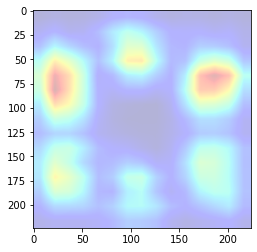

In [ ]:
plt.imshow(transforms.ToPILImage()(out), cmap = plt.cm.jet, interpolation="bicubic", alpha = 0.3)
print(out[0])
print(out.shape)

In [ ]:
# locate with position should be focused
out = out.detach()
def heapAttention(outAttention, positions):
    attTensor = torch.zeros(6, requires_grad=False)
    
    for i in range(6):
        x1, y1, x2, y2, cx, cy = positions[i]
        attTensor[i] = outAttention[0, x1:x2+1, y1:y2+1].sum()
        
    return np.argmax(attTensor.numpy())

In [ ]:
# to see whether matches ground truth
def findOrNot(imgID, heapid, df):
    if df.loc[imgID, 'targetCate'] == df.loc[imgID, 'arrayCate'][heapid]:
      return True
    return False

In [ ]:
# inhibit return: mask unmatched position
def maskUnmatchedPos(heapid, attentionMap, positions):
    x1, y1, x2, y2, cx, cy = positions[heapid]
    attentionMap[0, x1:x2+1, y1:y2+1] = 0
    return attentionMap

Try another way of customized dataset

In [ ]:
class MyDataset_v2(Dataset): 
  def __init__(self, path_dir_sti, path_dir_tg, transform_sti=None, transform_tg=None): 
    self.path_dir_sti = path_dir_sti 
    self.path_dir_tg = path_dir_tg 
    self.transform_sti = transform_sti
    self.transform_tg = transform_tg

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    img_path = self.path_dir_sti + 'array_' + str(idx) + '.jpg'
    tg_path = self.path_dir_tg + 'target_' + str(idx) + '.jpg'
    img = Image.open(img_path).convert('RGB')
    tg = Image.open(tg_path).convert('RGB')
    
    if self.transform_sti is not None:
      img = self.transform_sti(img)

    if self.transform_tg is not None:
      tg = self.transform_tg(tg)

    return img, tg

In [ ]:
# loop over 300 pics
path_dir_array = '/content/drive/MyDrive/Colab Notebooks/ObjectArray/stimuli/'
path_dir_target = '/content/drive/MyDrive/Colab Notebooks/ObjectArray/target/'

outAttentions = [_ for i in range(301)]
searchSeq300 = [[] for i in range(301)]
searchCount300 = [0 for i in range(301)]
for i in range(1,301):
  sti_tg = MyDataset_v2(path_dir_array, path_dir_target, data_transforms_stimu, data_transforms_target)
  sti_img, tg_img = sti_tg[i]

  sti_img = sti_img.view(1, 3, 224, 224)
  tg_img = tg_img.view(1, 3, 32, 32)

  output_stimuli = model_stimuli.forward(sti_img)
  output_target = model_target.forward(tg_img)
  
  MMconv.weight = torch.nn.Parameter(output_target)
  out_trial = MMconv.forward(output_stimuli).squeeze(0)
  out_trial = out_trial.detach()
  out_trial = attentionMapProcess(out_trial)
  outAttentions[i] = out_trial

  for j in range(6):
    id = heapAttention(out_trial, positions)
    searchCount300[i] += 1
    searchSeq300[i].append(id)
    if findOrNot(i, id, df_gd): 
      break
    else:
      out_trial = maskUnmatchedPos(id, out_trial, positions)


In [ ]:
np.mean(np.array(searchCount300))

2.5913621262458473

In [ ]:
import cv2 as cv

In [ ]:
positions.append([112, 112])
positions

[[133, 0, 179, 51, 156, 25],
 [44, 0, 90, 51, 67, 25],
 [0, 86, 45, 137, 22, 111],
 [44, 172, 90, 223, 67, 197],
 [133, 172, 179, 223, 67, 197],
 [178, 86, 223, 137, 200, 111],
 [112, 112]]

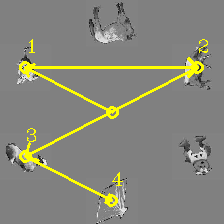

In [ ]:
# 224 * 224, center(112, 112)
from google.colab.patches import cv2_imshow
def scanPathShow(picdir, path, positions, index):
    # load and read image
    img_path = picdir + 'array_' + str(index) + '.jpg'
    pic = cv.imread(img_path)
    # resize image
    pic = cv.resize(pic, (224, 224), interpolation=cv.INTER_CUBIC)
    # draw circle and numbers
    path = np.array(path)
    path = [int(num) for num in path]
    cv.circle(pic,(112,112),5,(0,255,255),2,1)
    count = 0
    for num in path:
        id = int(num)
        count += 1
        cx, cy = positions[id][5], positions[id][4]
        cv.circle(pic,(cx, cy),5,(0,255,255),2,1)
        cv.putText(pic, str(count), (cx, cy - 15), cv.FONT_HERSHEY_COMPLEX, 0.6, (0,255,255), 1)
    
    # draw the arrows
    for i in range(len(path)):
        id = int(path[i])
        if i == 0:
            cx, cy = positions[id][5], positions[id][4]
            cv.arrowedLine(pic,(112, 112), (cx, cy), (0,255,255), 2, 0, 0, 0.1)
        else:
            id_start = int(path[i-1])
            id_end = int(path[i])
            cx_start, cy_start = positions[id_start][5], positions[id_start][4]
            cx_end, cy_end = positions[id_end][5], positions[id_end][4]
            cv.arrowedLine(pic,(cx_start, cy_start), (cx_end, cy_end), (0,255,255), 2, 0, 0, 0.07)
            
    cv2_imshow(pic)

scanPathShow(path_dir_array, searchSeq300[5], positions, 5)

In [ ]:
searchSeq300

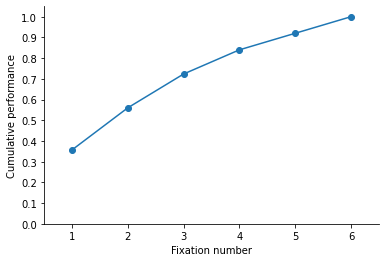

In [ ]:
# plot cumulative performance
counter = pd.value_counts(searchCount300[1:])
accu_performance = [0 for i in range(7)]
for i in range(1,7):
    accu_performance[i] = counter[:i].sum()/counter.sum()

plt.plot(range(1,7), accu_performance[1:], marker = 'o', linestyle = '-')
plt.axis([0.5, 6.5, 0, 1.05])
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(0.1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Fixation number')
plt.ylabel('Cumulative performance')
plt.show()